In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Veriyi yükle
df = pd.read_csv('data.csv')

# Sütun isimlerini temizle
df.columns = df.columns.str.strip()

# İsmi karışık diye değişkene atadım.
hedef_sutun = 'NO2(µg/m3)' 

# Sayısal olmayan veya 'ID', 'Date' gibi gereksiz sütunları çıkardım.
print("Veri yüklendi, ilk 5 satır:")
display(df.head())

Veri yüklendi, ilk 5 satır:


,ID,Date,Temperature(C),Humidity(%),WindSpeed(km/h),Rain(mm),TrafficVolume(vehicles/hour),NO2(µg/m3),SO2(µg/m3),CO(mg/m3),...,AQI_PM2.5,AQI_PM10,AQI_NO2,AQI_SO2,AQI_CO,AQI Value,AQI Category,Country,lat,lng
0,1,2023-01-01,32.5,56.7,14.7,2.5,882.0,41.4,9.7,0.25,...,162.5,78.9,39.1,13.9,2.8,162.5,Unhealthy,Bulgaria,42.5000,23.0000
1,2,2023-01-02,29.3,54.9,14.6,0.5,2629.0,29.0,11.5,1.32,...,125.1,72.6,27.4,16.4,15.0,125.1,Unhealthy for Sensitive Groups,Serbia,44.5000,20.2000
2,3,2023-01-03,33.2,61.5,21.0,6.3,2350.0,45.5,22.2,0.63,...,155.2,62.3,42.9,31.7,7.2,155.2,Unhealthy,North Macedonia,41.8000,21.2000
3,4,2023-01-04,37.6,67.7,15.1,4.9,1331.0,33.4,19.8,1.11,...,161.1,73.4,31.5,28.3,12.6,161.1,Unhealthy,Portugal,38.5000,-8.0000
4,5,2023-01-05,28.8,83.8,12.9,0.5,3200.0,39.1,21.1,1.13,...,155.0,82.0,36.9,30.1,12.8,155.0,Unhealthy,United Kingdom,51.5074,-0.1278


Seçilen En Etkili Özellik (X): Humidity(%)


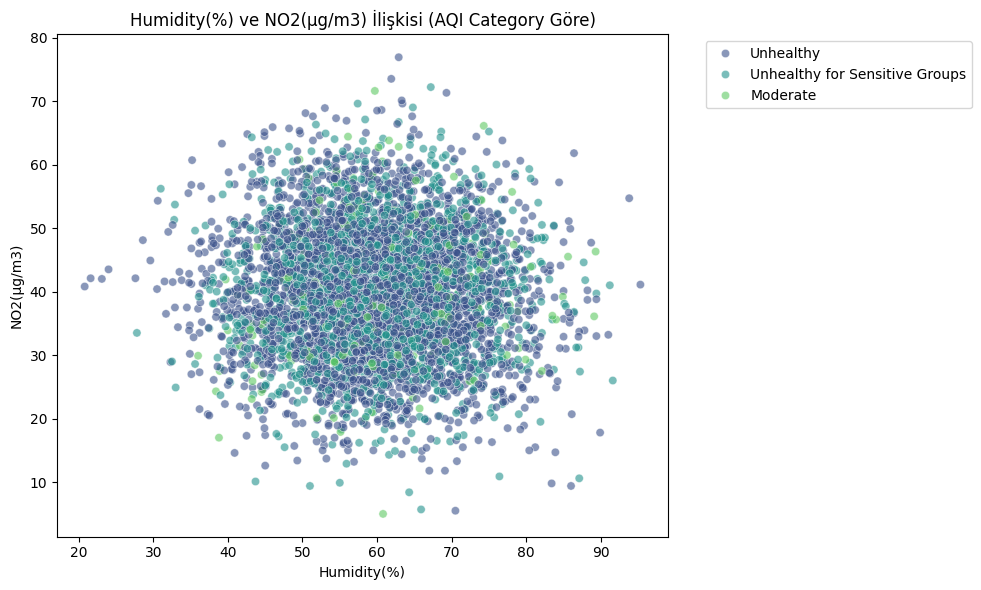

In [6]:
# Önce sayısal sütunları seçip en iyi özelliği buldum
sayisal_veri = df.select_dtypes(include=[np.number]).dropna()

# Kopya sütunları kopya çekmesin diye çıkardım
gecerli_sutunlar = [c for c in sayisal_veri.columns if 'AQI' not in c and c != 'ID']
korelasyon = sayisal_veri[gecerli_sutunlar].corr()

# NO2 ile en yüksek ilişkisi olan özelliği buldum
en_etkili_ozellik = korelasyon[hedef_sutun].drop(hedef_sutun).abs().idxmax()
print(f"Seçilen En Etkili Özellik (X): {en_etkili_ozellik}")

# Grafik çizimi
plt.figure(figsize=(10, 6))
# Eğer 'AQI Category' sütunu varsa onu kullan yoksa 'Season' kullanma
renk_kategorisi = 'AQI Category' if 'AQI Category' in df.columns else 'Season'

sns.scatterplot(x=en_etkili_ozellik, y=hedef_sutun, data=df, alpha=0.6, hue=renk_kategorisi, palette='viridis')

plt.title(f'{en_etkili_ozellik} ve {hedef_sutun} İlişkisi ({renk_kategorisi} Göre)')
plt.xlabel(en_etkili_ozellik)
plt.ylabel(hedef_sutun)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Lejantı dışarı al
plt.tight_layout()
plt.show()


In [7]:

# Sadece eksik olmayan verileri aldım
temiz_veri = df[[en_etkili_ozellik, hedef_sutun]].dropna()

X = temiz_veri[[en_etkili_ozellik]]
y = temiz_veri[hedef_sutun]

# 2. Eğitim ve Test olarak ayırdım. (%80 - %20)
X_egitim, X_test, y_egitim, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modeli kurup eğitme
model = LinearRegression()
model.fit(X_egitim, y_egitim)

print("Model eğitimi tamamlandı.")
print(f"Eğim : {model.coef_[0]:.4f}")
print(f"Sabit Değer : {model.intercept_:.4f}")

Model eğitimi tamamlandı.
Eğim : -0.0382
Sabit Değer : 42.1706


R2 Skoru (Model Başarısı): 0.00
Ortalama Kare Hata (MSE): 101


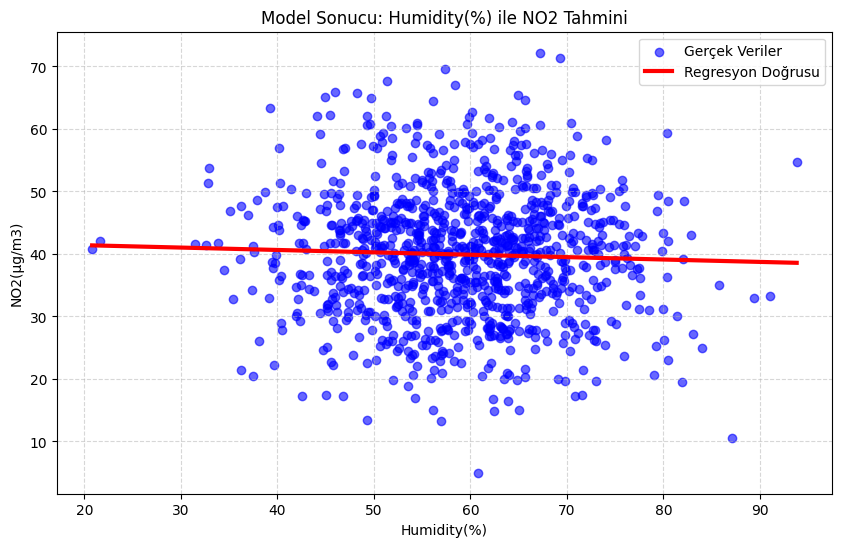

In [8]:
# Tahmin yap
y_tahmin = model.predict(X_test)

# Başarı metrikleri
r2_skoru = r2_score(y_test, y_tahmin)
hata_kareler = mean_squared_error(y_test, y_tahmin)

print(f"R2 Skoru (Model Başarısı): {r2_skoru:.2f}")
print(f"Ortalama Kare Hata (MSE): {hata_kareler:.0f}")

# Grafik Çiz
plt.figure(figsize=(10, 6))

# Gerçek veriler (Mavi)
plt.scatter(X_test[en_etkili_ozellik], y_test, color='blue', alpha=0.6, label='Gerçek Veriler')

# Tahmin çizgisi (Kırmızı)
sirali_indeks = X_test[en_etkili_ozellik].argsort()
plt.plot(X_test.iloc[sirali_indeks][en_etkili_ozellik], y_tahmin[sirali_indeks], color='red', linewidth=3, label='Regresyon Doğrusu')

plt.title(f'Model Sonucu: {en_etkili_ozellik} ile NO2 Tahmini')
plt.xlabel(en_etkili_ozellik)
plt.ylabel(hedef_sutun)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

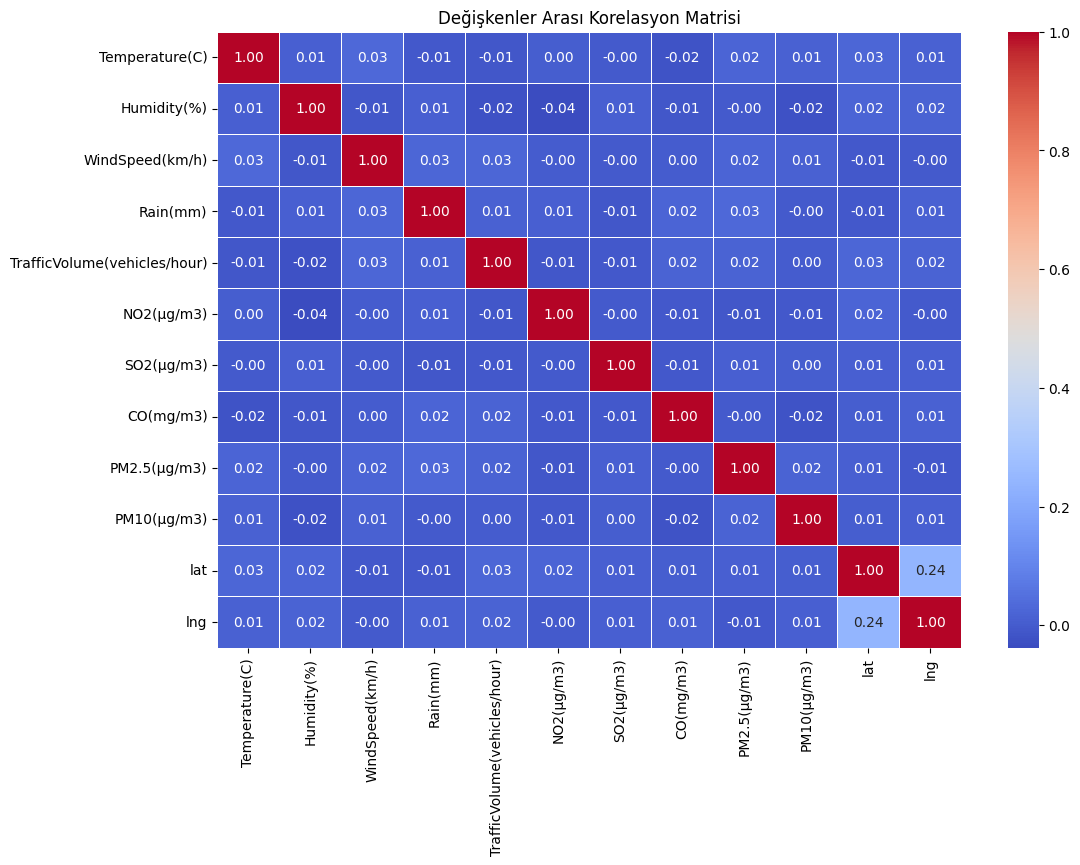

In [ ]:
# Sadece sayısal verileri ve AQI olmayanları aldım
heatmap_sutunlari = [c for c in sayisal_veri.columns if 'AQI' not in c and 'ID' not in c]
heatmap_verisi = df[heatmap_sutunlari]

# Korelasyon matrisi
korelasyon_matrisi = heatmap_verisi.corr()

# Isı Haritası
plt.figure(figsize=(12, 8))
sns.heatmap(korelasyon_matrisi, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Değişkenler Arası Korelasyon Matrisi')
plt.show()

In [9]:
# Seçilen özelliğin (X) ortalama bir değerini bulup tahmin ettirelim
ornek_deger = X[en_etkili_ozellik].mean()

# Hata almamak için
girdi_verisi = pd.DataFrame({en_etkili_ozellik: [ornek_deger]})

tahmin_sonucu = model.predict(girdi_verisi)

print(f"Girilen {en_etkili_ozellik} Değeri: {ornek_deger:.2f}")
print(f"Modelin NO2 Tahmini: {tahmin_sonucu[0]:.2f} µg/m3")

Girilen Humidity(%) Değeri: 59.90
Modelin NO2 Tahmini: 39.88 µg/m3
